# **In This Notebook**
We went through MayoClinic - StripAI dataset with analyzing and visualizing the data through different types of visualizations, then we ran 2 models with different approaches to solve data unbalancing issue.

**Team:**

1- Omar Khaled

2- Nour Ehab

3- Abdalrahman Al-jammal

4- Philopateer Magdy

In [1]:
import numpy as np 
import pandas as pd 
import os
import keras.backend as K 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


## Data viusalization

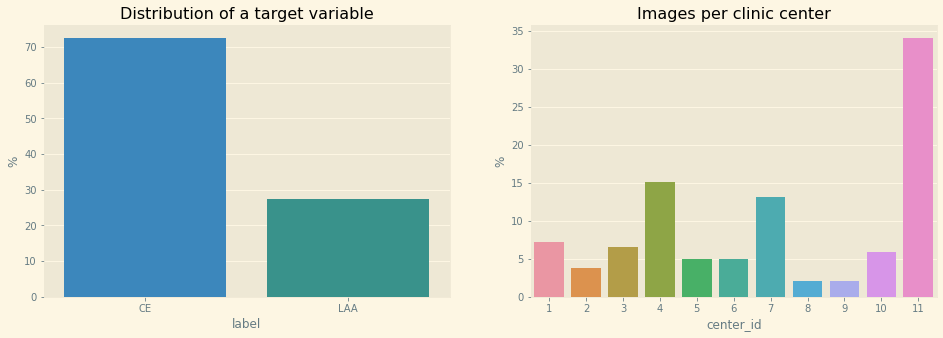

Train Size = 754
Test Size = 4


In [3]:
plt.style.use('Solarize_Light2')
labels = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
centers = train_df.groupby("center_id")['center_id'].count().div(len(train_df)).mul(100)
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.barplot(x=labels.index, y=labels.values, ax=ax[0])
ax[0].set_title("Distribution of a target variable"), ax[0].set_ylabel("%")
sns.barplot(x=centers.index, y=centers.values, ax=ax[1])
ax[1].set_title("Images per clinic center"), ax[1].set_ylabel("%")
plt.show()
print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))

## From this plot we notice that there is a class imbalance which we will deal with later in this notebook

In [4]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
other_images = glob("/kaggle/input/mayo-clinic-strip-ai/other/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")
print(f"Number of other: {len(other_images)}")

Number of images in a training set: 754
Number of images in a training set: 4
Number of other: 396


In [5]:
img_prop = defaultdict(list)
for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)
image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)
image_data = image_data.merge(train_df, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


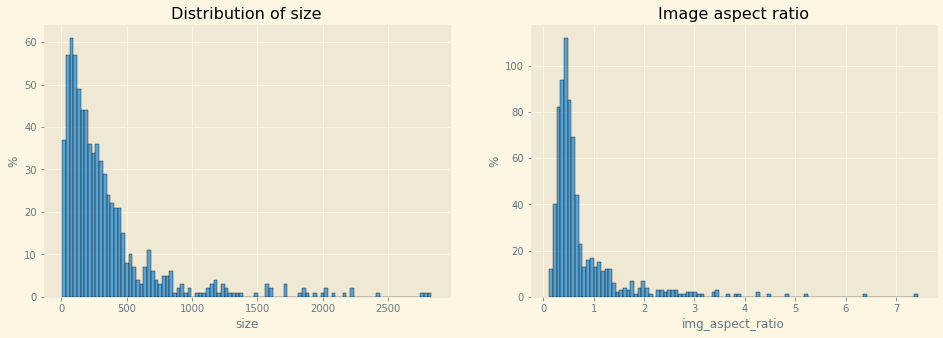

In [6]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(x='size', data = image_data, bins=100, ax=ax[0])
ax[0].set_title("Distribution of size"), ax[0].set_ylabel("%")
sns.histplot(x='img_aspect_ratio', data = image_data, bins=100, ax=ax[1])
ax[1].set_title("Image aspect ratio"), ax[1].set_ylabel("%")
plt.show()

# **Some Image Displaying on the data**

In [ ]:
def reading_tiff(image):
    Reading_Image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    return Reading_Image

In [ ]:
def single_display_tiff(image):
    figure = plt.figure(figsize=(20,20))
    Reading_Image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    plt.xlabel(Reading_Image.shape)
    plt.ylabel(Reading_Image.size)
    plt.title("TIFF")
    plt.imshow(Reading_Image)

In [ ]:
def threshold_display(image):
    figure = plt.figure(figsize=(8,8))
    Reading_Image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    _,Threshold_Image = cv2.threshold(Reading_Image,30,255,cv2.THRESH_BINARY)
    plt.xlabel(Threshold_Image.shape)
    plt.ylabel(Threshold_Image.size)
    plt.title("THRESHOLD")
    plt.imshow(Threshold_Image)
def threshold_reading(image):
    Reading_Image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    _,Threshold_Image = cv2.threshold(Reading_Image,30,255,cv2.THRESH_BINARY)
    return Threshold_Image

In [ ]:
def adaptive_threshold_display(image):
    figure = plt.figure(figsize=(8,8))
    Reading_Image = cv2.imread(image,0)
    Adaptive_Image = cv2.adaptiveThreshold(Reading_Image,20,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,2)
    plt.xlabel(Adaptive_Image.shape)
    plt.ylabel(Adaptive_Image.size)
    plt.title("ADAPTIVE_THRESHOLD")
    plt.imshow(Adaptive_Image)
def adaptive_threshold_reading(image):
    Reading_Image = cv2.imread(image,0)
    Adaptive_Image = cv2.adaptiveThreshold(Reading_Image,20,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,9,2)
    return Adaptive_Image

In [ ]:
def canny_reading(image):
    Reading_Image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    Canny_Image = cv2.Canny(Reading_Image,5,100)
    return Canny_Image

In [ ]:
def bitwise_and_display(image):
    figure = plt.figure(figsize=(8,8))
    Reading_Image = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    Reading_Image = cv2.resize(Reading_Image,(180,180))
    _,Threshold_Image = cv2.threshold(Reading_Image,30,255,cv2.THRESH_BINARY)
    Threshold_Image = cv2.resize(Threshold_Image,(180,180))
    Mask_For_Image = cv2.inRange(Reading_Image,Reading_Image,Threshold_Image)
    Bitwise_Image = cv2.bitwise_and(Reading_Image,Reading_Image,mask=Mask_For_Image)
    plt.xlabel(Bitwise_Image.shape)
    plt.ylabel(Bitwise_Image.size)
    plt.title("Bitwise_Image")
    plt.imshow(Bitwise_Image)

In [ ]:
def different_type_display(image_one,image_two,image_three,image_four):
    figure,axis = plt.subplots(1,4,figsize=(10,12))
    axis[0].imshow(image_one)
    axis[0].set_xlabel(image_one.shape)
    axis[0].set_ylabel(image_one.size)
    axis[0].set_title("image_one")
    axis[1].imshow(image_two)
    axis[1].set_xlabel(image_two.shape)
    axis[1].set_ylabel(image_two.size)
    axis[1].set_title("image_two")
    axis[2].imshow(image_three)
    axis[2].set_xlabel(image_three.shape)
    axis[2].set_ylabel(image_three.size)
    axis[2].set_title("image_three")
    axis[3].imshow(image_four)
    axis[3].set_xlabel(image_four.shape)
    axis[3].set_ylabel(image_four.size)
    axis[3].set_title("image_four")

# **Dispalying TIFF images**

In [ ]:
plt.style.use("dark_background")
single_display_tiff('../input/mayo-clinic-strip-ai/train/0cc0bc_0.tif')

In [ ]:
plt.style.use("dark_background")
threshold_display('../input/mayo-clinic-strip-ai/train/0cc0bc_0.tif')

In [ ]:
plt.style.use("dark_background")
adaptive_threshold_display('../input/mayo-clinic-strip-ai/train/0cc0bc_0.tif')

In [ ]:
figure = plt.figure(figsize=(8,8))
Canny_Image = canny_reading('../input/mayo-clinic-strip-ai/train/0cc0bc_0.tif')
plt.imshow(Canny_Image)
plt.axis("off")

In [ ]:
bitwise_and_display('../input/mayo-clinic-strip-ai/train/0cc0bc_0.tif')

# **Analyzing CE class**

In [ ]:
Reading_Image=reading_tiff('../input/mayo-clinic-strip-ai/train/31adaa_0.tif')
figure = plt.figure(figsize=(20,20))
plt.imshow(Reading_Image)


In [ ]:
different_type_display(reading_tiff('../input/mayo-clinic-strip-ai/train/31adaa_0.tif'),
                      threshold_reading('../input/mayo-clinic-strip-ai/train/31adaa_0.tif'),
                      adaptive_threshold_reading('../input/mayo-clinic-strip-ai/train/31adaa_0.tif'),
                      canny_reading('../input/mayo-clinic-strip-ai/train/31adaa_0.tif'))

In [ ]:
plt.style.use("dark_background")
single_display_tiff('../input/mayo-clinic-strip-ai/train/1b86c5_0.tif')

In [ ]:
different_type_display(reading_tiff('../input/mayo-clinic-strip-ai/train/1b86c5_0.tif'),
                      threshold_reading('../input/mayo-clinic-strip-ai/train/1b86c5_0.tif'),
                      adaptive_threshold_reading('../input/mayo-clinic-strip-ai/train/1b86c5_0.tif'),
                      canny_reading('../input/mayo-clinic-strip-ai/train/1b86c5_0.tif'))

# **Analyzing LAA class**

In [ ]:
plt.style.use("dark_background")
single_display_tiff('../input/mayo-clinic-strip-ai/train/6f6e0c_0.tif')

In [ ]:
different_type_display(reading_tiff('../input/mayo-clinic-strip-ai/train/6f6e0c_0.tif'),
                      threshold_reading('../input/mayo-clinic-strip-ai/train/6f6e0c_0.tif'),
                      adaptive_threshold_reading('../input/mayo-clinic-strip-ai/train/6f6e0c_0.tif'),
                      canny_reading('../input/mayo-clinic-strip-ai/train/6f6e0c_0.tif'))

In [ ]:
plt.style.use("dark_background")
single_display_tiff('../input/mayo-clinic-strip-ai/train/ed5006_0.tif')

In [ ]:
plt.style.use("dark_background")
single_display_tiff('../input/mayo-clinic-strip-ai/train/a2c497_0.tif')

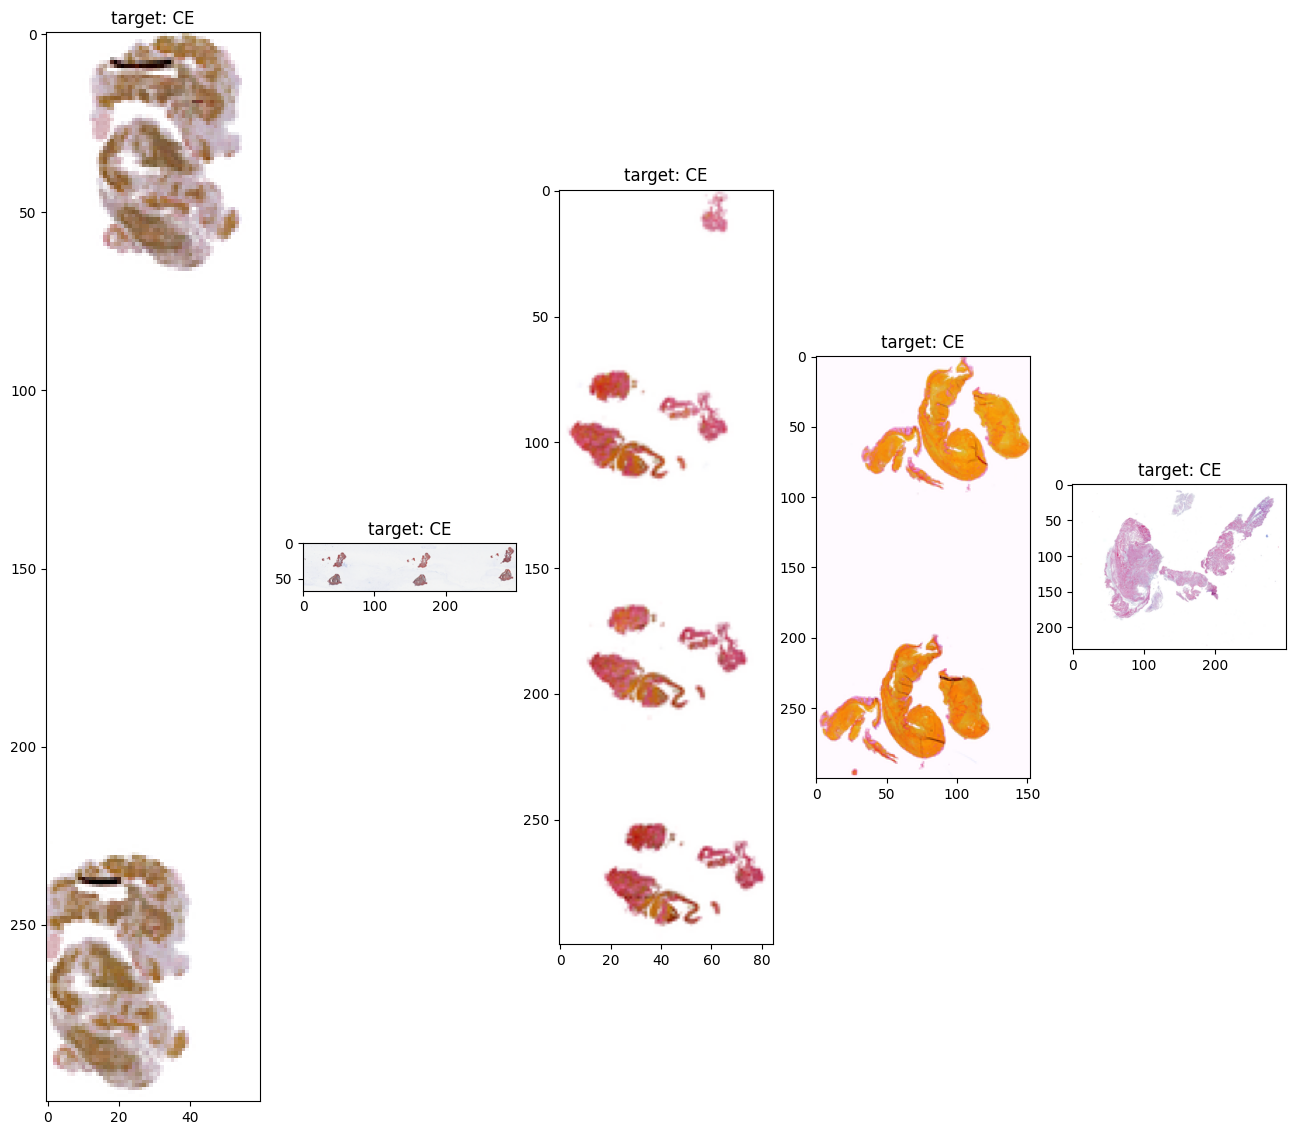

In [10]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']


plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

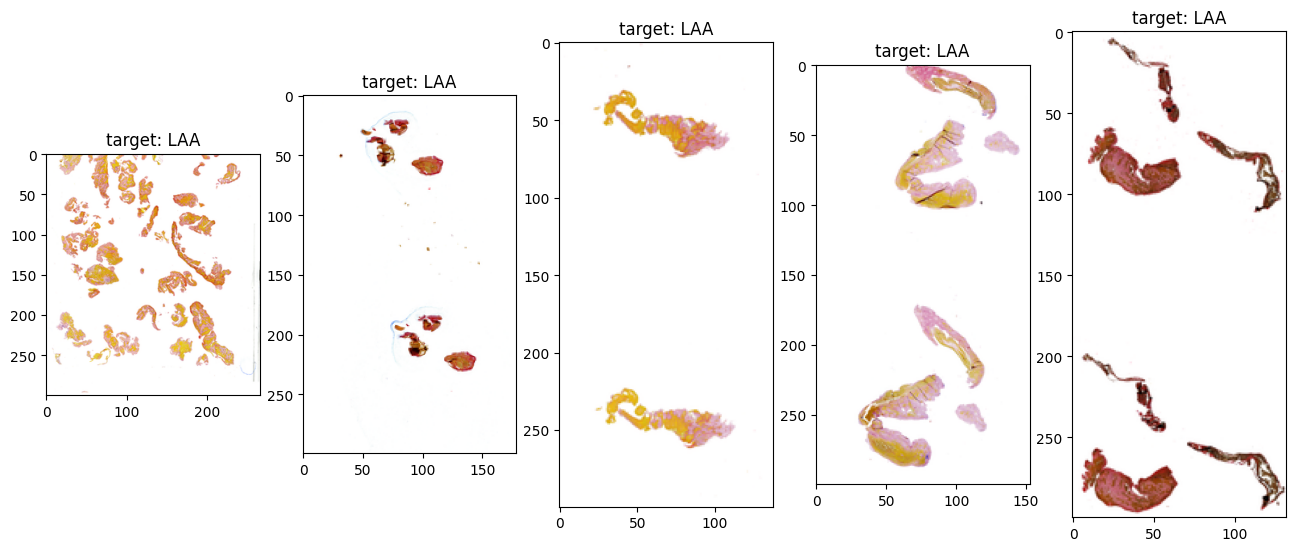

In [11]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_images
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

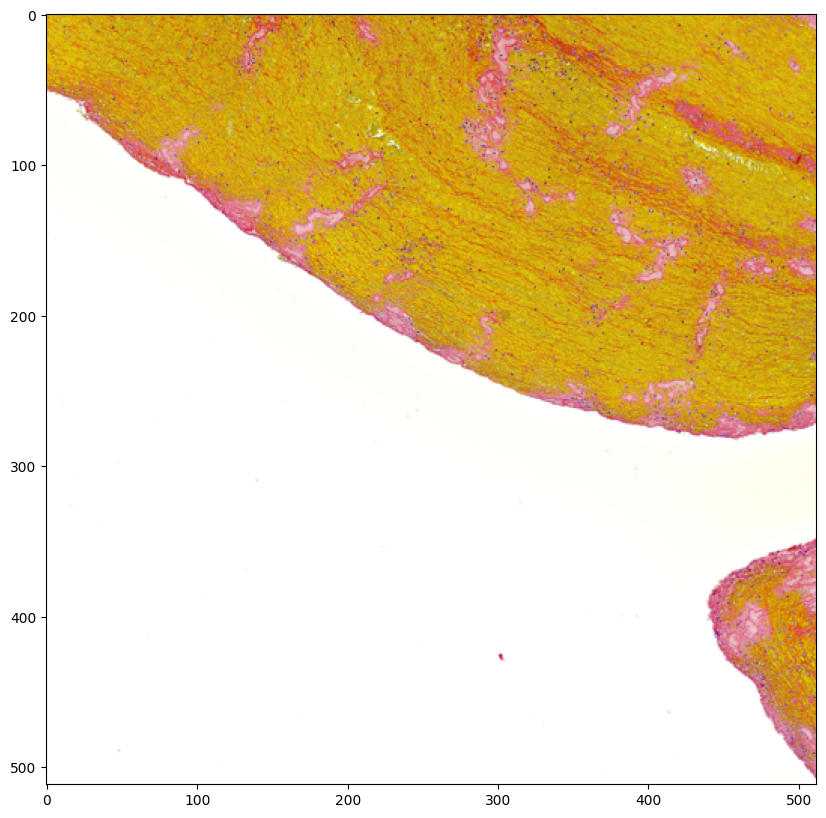

In [12]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') # opening a full slide

region = (2500, 2000) # location of the top left pixel
level = 0 # level of the picture (we have only 0)
size = (3500, 3500) # region size in pixels

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


## **Solution 1:**
Balancing the weights

In [7]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [8]:
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


## Preprocessing

In [9]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (1000,1000)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((512, 512))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

100%|██████████| 754/754 [47:13<00:00,  3.76s/it] 

CPU times: user 16min 49s, sys: 3min 22s, total: 20min 11s
Wall time: 47min 13s


In [10]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [ ]:
## Splitting data
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2)

In [12]:
print(x_train.shape)

(754, 512, 512, 4)


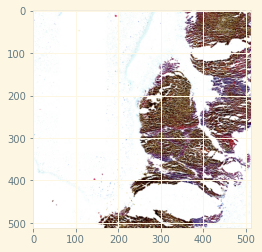

In [13]:
plt.imshow(x_train[0])

## CNN Model

In [14]:
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [15]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
model = Sequential()
input_shape = (512, 512, 4)
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', input_shape = input_shape))
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)))
model.add(Dropout(0.50))
model.add(Dense(1))
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), 
             tf.keras.metrics.BinaryAccuracy(name="accuracy"),f1_score,precision],
    optimizer = tf.keras.optimizers.Adam(1e-4))

2023-02-19 12:05:18.653433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 12:05:18.822808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 12:05:18.823693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-19 12:05:18.825932: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

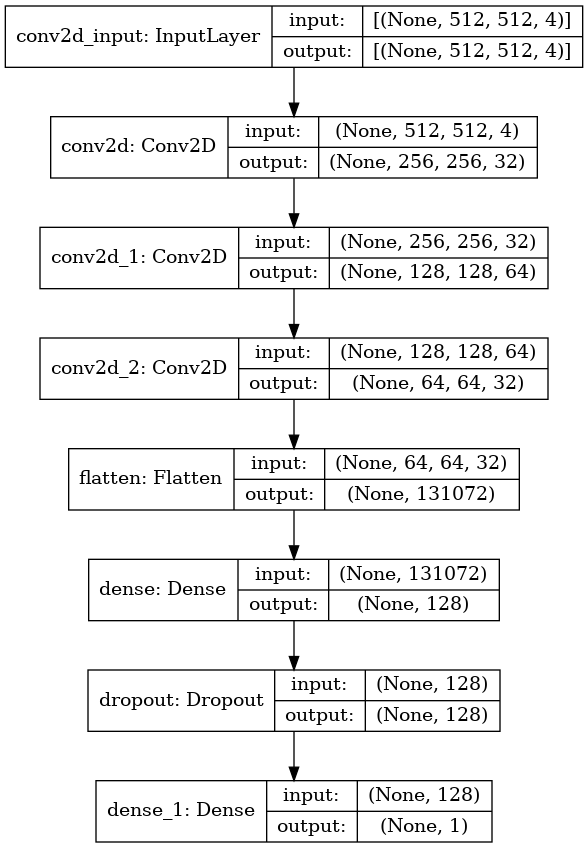

In [17]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [18]:
#This is where we balance class weights
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 1.821256038647343, 1: 0.6892138939670932}

## Training the model

In [19]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='our_cnn_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [60]:
model.fit(
    X_train,
    y_train,
    epochs = 1000,
    batch_size=32,
    shuffle=True,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback
)

Epoch 1/50
38/38 [==============================] - 2s 21ms/step - loss: 0.6932 - binary_accuracy: 0.5506 - f1_score: 0.5324 - mae: 0.4896 - accuracy: 0.5506 - precision: 0.5840 - sensitivity: 0.5836 - specificity: 0.4890 - rmse: 0.4935 - val_loss: 0.6983 - val_binary_accuracy: 0.3245 - val_f1_score: 0.0348 - val_mae: 0.5025 - val_accuracy: 0.3245 - val_precision: 0.1500 - val_sensitivity: 0.0200 - val_specificity: 0.9633 - val_rmse: 0.5026

Epoch 00001: val_binary_accuracy did not improve from 0.68212
Epoch 2/50
38/38 [==============================] - 0s 11ms/step - loss: 0.6842 - binary_accuracy: 0.5274 - f1_score: 0.5130 - mae: 0.4957 - accuracy: 0.5274 - precision: 0.6303 - sensitivity: 0.5491 - specificity: 0.4531 - rmse: 0.4961 - val_loss: 0.6939 - val_binary_accuracy: 0.5099 - val_f1_score: 0.6222 - val_mae: 0.5004 - val_accuracy: 0.5099 - val_precision: 0.6979 - val_sensitivity: 0.5953 - val_specificity: 0.4983 - val_rmse: 0.5004

Epoch 00002: val_binary_accuracy did not impro

In [61]:
best_cnn = load_model('/kaggle/working/our_cnn_best.h5', custom_objects={"f1_score": f1_score })
p=model.evaluate(x_test,y_test)
p

5/5 [==============================] - 0s 9ms/step - loss: 3.0893 - binary_accuracy: 0.6291 - f1_score: 0.7598 - mae: 0.4046 - accuracy: 0.6291 - precision: 0.6727 - sensitivity: 0.8830 - specificity: 0.1017 - rmse: 0.5645


[3.0892720222473145,
 0.6291390657424927,
 0.7598341107368469,
 0.40455368161201477,
 0.6291390657424927,
 0.6726640462875366,
 0.8829706311225891,
 0.10166666656732559,
 0.5645046234130859]

Text(0.5, 25.722222222222214, 'Actual')

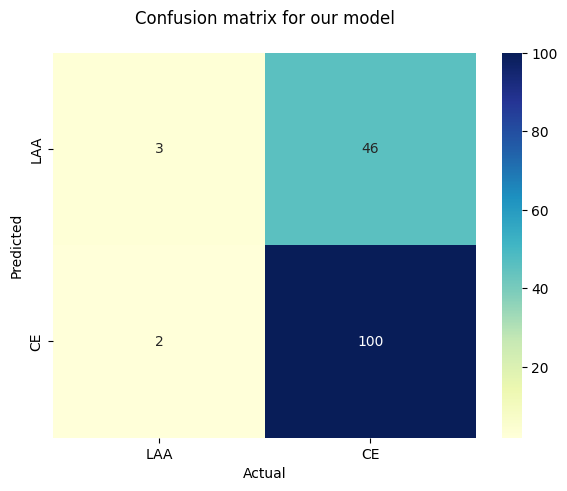

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_cnn.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

## Submission for kaggle competition

In [ ]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1)
    print(i)
    
test1=np.array(test1)


In [ ]:
cnn_pred=model.predict(test1)
cnn_pred

In [ ]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

In [ ]:
sub.to_csv("submission.csv", index = False)
!head submission.csv

# Solution 2
Using DenseNET

In [ ]:
del X_train
del Y_train

In [ ]:
train_df.head()

In [ ]:
%%time
def preprocess_RGB(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size).convert('RGB')
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    #print(i)
    x1=preprocess_RGB(i)
    X_train.append(x1)
    
Y_train=train_df['target']

In [ ]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [ ]:
CE = 0
LAA = 0
for i in y_test:
    if i ==1:
        CE = CE+1
    else:
        LAA = LAA + 1
print(CE)
print(LAA)

In [ ]:
plt.imshow(x_test[0])

In [ ]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from keras import layers
from keras import metrics

effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(128,128,3)
)
print(len(effnet.layers))
for layer in effnet.layers[0:200]:
    layer.trainable = True
for layer in effnet.layers[201::]:
    layer.trainable = False
Dense_model = Sequential()
Dense_model.add(effnet)
Dense_model.add(layers.GlobalAveragePooling2D())
Dense_model.add(layers.Dropout(0.5))
Dense_model.add(layers.Dense(512,activation='relu'))
Dense_model.add(layers.Dense(64,activation='relu'))
Dense_model.add(layers.Dense(1, activation='sigmoid'))
Dense_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-3))
Dense_model.summary()

In [ ]:
dot_img_file = 'model.png'
tf.keras.utils.plot_model(Dense_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='Dense_best.h5',
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True, verbose=1)

In [ ]:
Dense_model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size=20,
    validation_data = (x_test,y_test),
    class_weight= class_weights,
    callbacks = callback2   
)

In [ ]:
best_Dense = load_model('/kaggle/working/Dense_best.h5', custom_objects={"f1_score": f1_score })
best_Dense.evaluate(x_test,y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15, 5))
preds = best_Dense.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")